In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
!which python

/data/miniconda3/envs/zoobot/bin/python


In [19]:
import os

import numpy as np
import pandas as pd
import matplotlib
# 
import matplotlib.pyplot as plt
import seaborn as sns

from zoobot.active_learning import metrics, simulated_metrics, simulation_timeline
from zoobot.tests import TEST_FIGURE_DIR
from zoobot.uncertainty import discrete_coverage


In [9]:
!cd /data/repos/zoobot

In [10]:
!pwd

/Data/repos/zoobot/analysis/uncertainty/coverage


In [11]:
state = metrics.load_iteration_state('../al-binomial/five_conv_fractions_with_id')

In [20]:
usecols = simulation_timeline.ATTR_STRS + ['subject_id', 'smooth-or-featured_smooth_fraction'] 
catalog = pd.read_csv('../../../data/panoptes_predictions_selected.csv', usecols=usecols, dtype={'subject_id': str})
model = metrics.Model(state, name='five_conv_fractions')
sim_model = simulated_metrics.SimulatedModel(model, catalog)

/Data/repos/zoobot/zoobot/active_learning/simulated_metrics.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  filtered_catalog['subject_id'] = filtered_catalog['subject_id'].astype(str)


### View Coverage, Compare Single and Many Samples

In [21]:
coverage_df = discrete_coverage.evaluate_discrete_coverage(sim_model.votes, sim_model.model.bin_probs)

In [22]:
coverage_df_single = discrete_coverage.evaluate_discrete_coverage(sim_model.votes, np.expand_dims(sim_model.model.bin_probs[:, 0, :], axis=1))

/Data/repos/zoobot/zoobot/uncertainty/discrete_coverage.py:6: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/data/miniconda3/envs/zoobot/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/data/miniconda3/envs/zoobot/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/data/miniconda3/envs/zoobot/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/data/miniconda3/envs/zoobot/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/data/miniconda3/envs/zoobot/lib/python3.6/site-packages/ipykernel/kernelapp.py", line

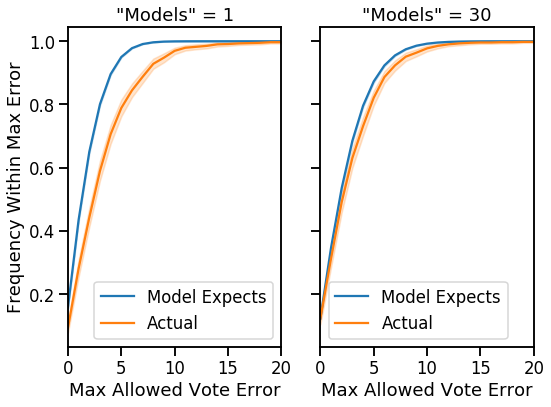

In [25]:
sns.set_context('talk')
fig, (ax0, ax1) = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(8, 6))
discrete_coverage.plot_coverage_df(coverage_df_single, ax0)  
discrete_coverage.plot_coverage_df(coverage_df, ax1)
ax0.set_title('"Models" = 1')
ax1.set_title('"Models" = 30')
ax0.set_xlim([0, 20])
ax1.set_xlim([0, 20])
fig.tight_layout()
fig.savefig('discrete_coverage_comparison.png')

In [7]:
# shuffled_votes = model.votes.copy()
# np.random.shuffle(shuffled_votes)  # inplace
# coverage_df_random = discrete_coverage.evaluate_discrete_coverage(shuffled_votes, model.bin_probs)
# discrete_coverage.plot_coverage_df(coverage_df_random, 'discrete_coverage_random.png')

### Develop New Coverage Metric (Abandoned)

Categorical classes are not equivalently distant, so this is not a sensible metric.
We care about how many classes over we are, not 'correct class or not'.

In [ ]:
assert False

In [43]:
def precise_coverage(coverage_df):
    df = coverage_df[coverage_df['max_state_error'] == 0]
    del df['max_state_error']
    df['correct'] = df['actual_k'] == np.around(df['prediction'] * 40)
    df['binned_predictions'] = pd.cut(df['prediction'], bins=100, labels=False)
    return df

In [44]:
df = precise_coverage(coverage_df)

/media/mike/internal/virtualenv/py36/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/media/mike/internal/virtualenv/py36/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [45]:
df.head()

,actual_k,max_k,min_k,most_likely_k,observed,prediction,correct,binned_predictions
0,13.0,10,10,10,0.0,0.113723,False,7
42,12.0,6,6,6,0.0,0.105852,False,6
84,31.0,31,31,31,1.0,0.139936,False,11
126,13.0,18,18,18,0.0,0.093242,False,4
168,18.0,15,15,15,0.0,0.076626,False,2


In [46]:
df_grouped = df.groupby('binned_predictions').agg({'correct': 'mean'}).reset_index()

In [47]:
fig, ax = plt.subplots()
sns.lineplot(data=df_grouped, x='binned_predictions', y='correct', ax=ax)
# ax.set_xlim([0, 100])
fig.tight_layout()
fig.savefig('precise_coverage.png')